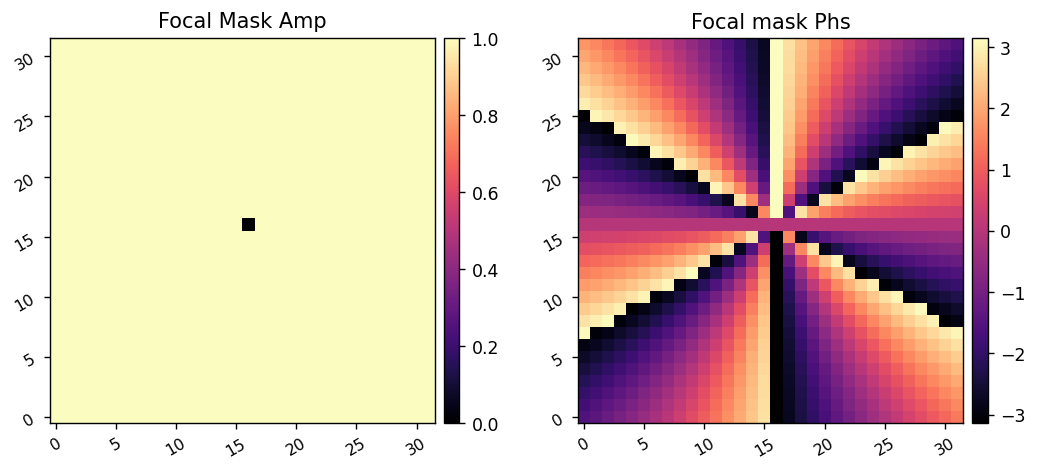

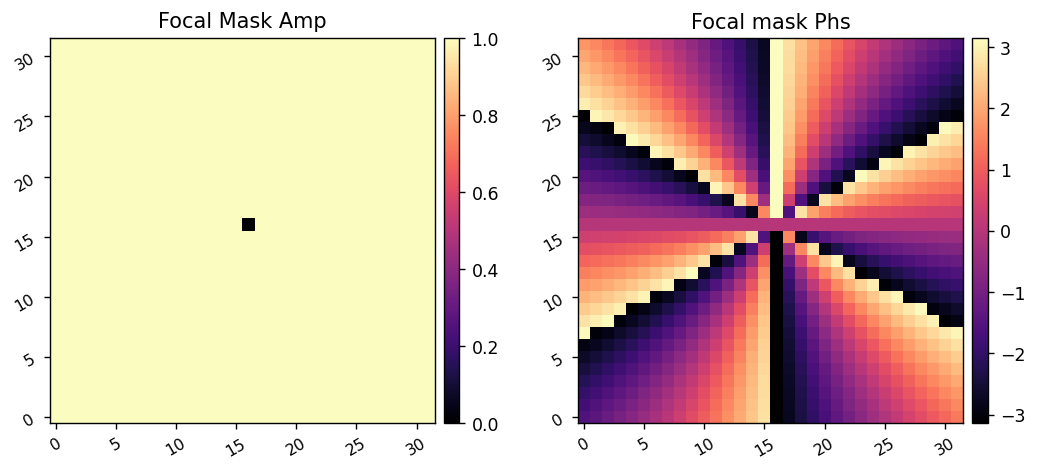

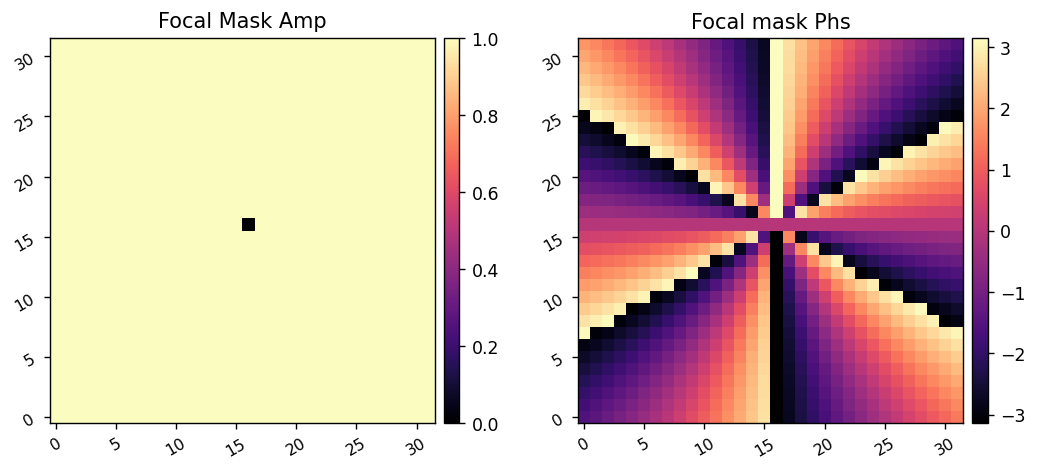

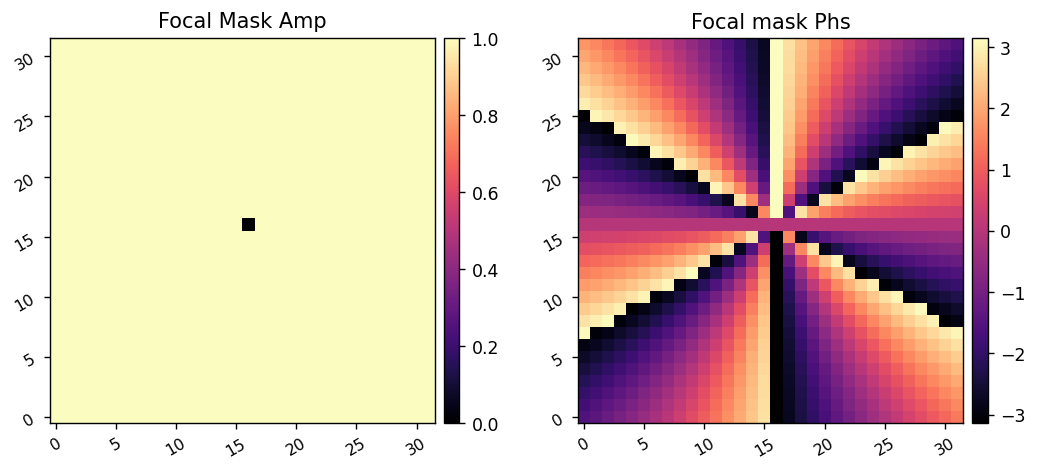

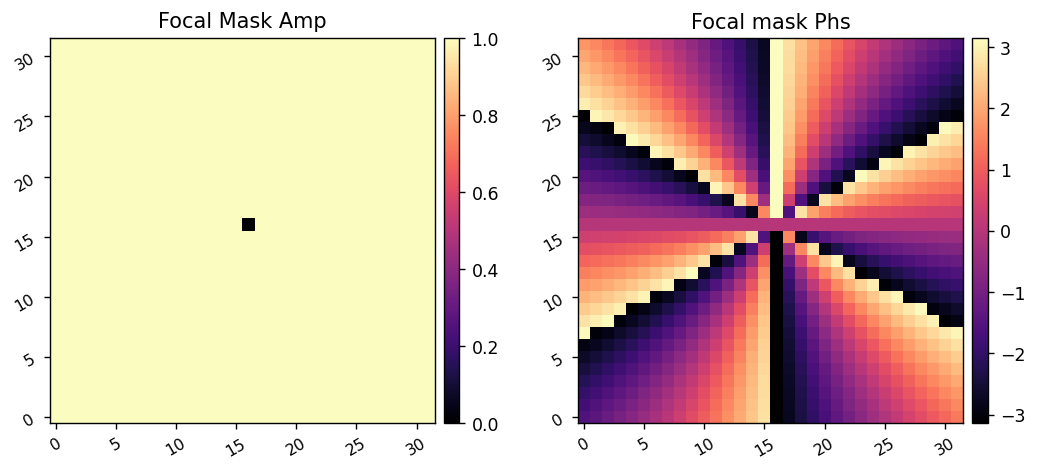

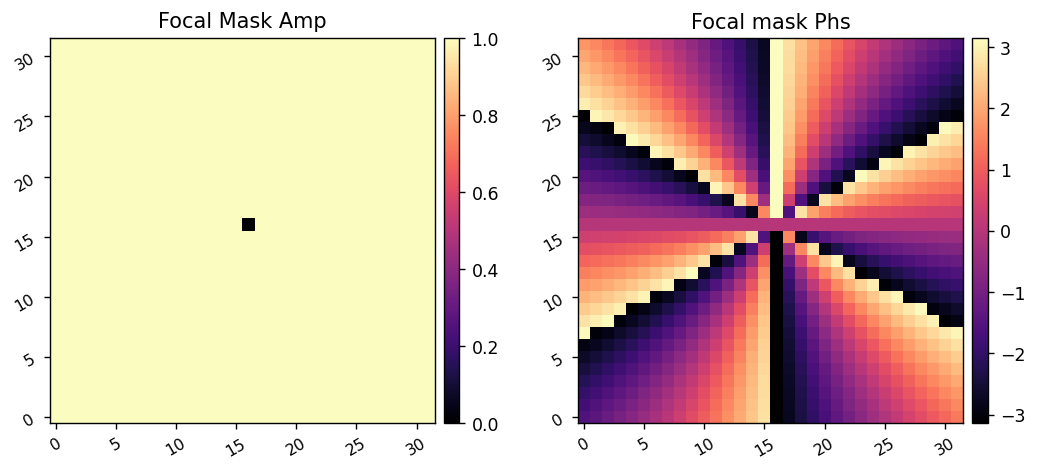

In [9]:
import numpy as np
import scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci
from hcipy.coronagraphy import vortex
reload(hci.coronagraphy.vortex)

import math_module
from math_module import xp
import iefc_2dm 
import utils
from imshows import *

math_module.update_np(np)
math_module.update_scipy(scipy)

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

import misc_funs as misc

import hcipy_models as hcim
reload(hcim)

reload(hci)

npix = 256
oversample = 4
c = hcim.SVC(npix=npix, oversample=oversample)


In [5]:
from hcipy.coronagraphy import vortex
reload(vortex)

<module 'hcipy.coronagraphy.vortex' from '/home/kianmilani/Projects/hcipy/hcipy/coronagraphy/vortex.py'>

In [9]:
influence_functions = hci.make_gaussian_influence_functions(c.pupil_grid, c.Nact, c.actuator_spacing)


34 952


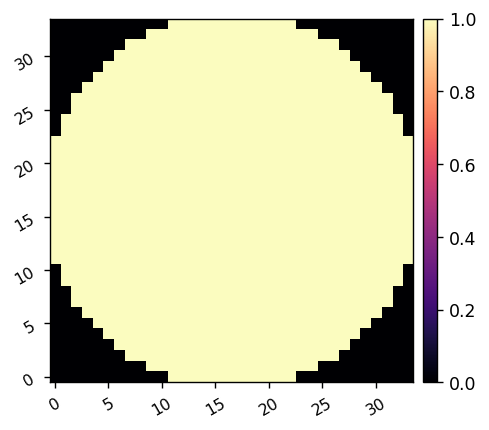

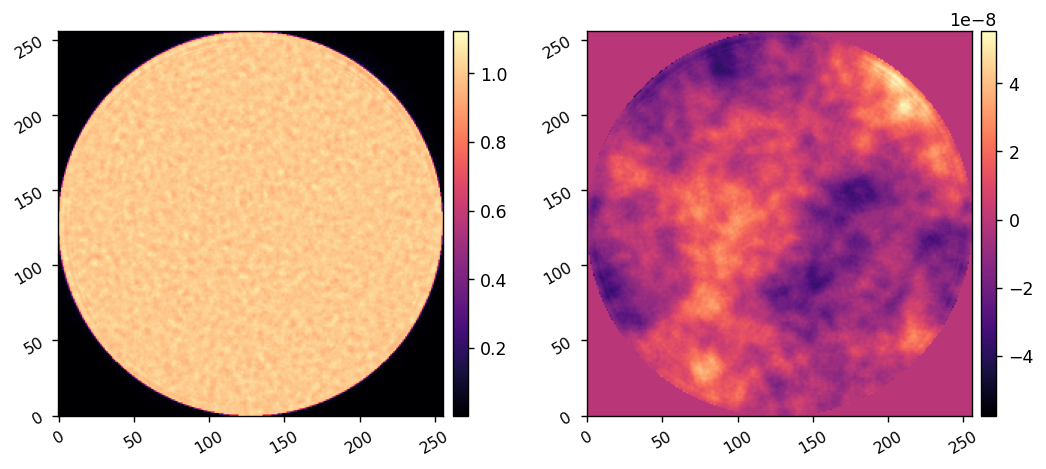

0.05958821785753578 1.4358778260304552e-08


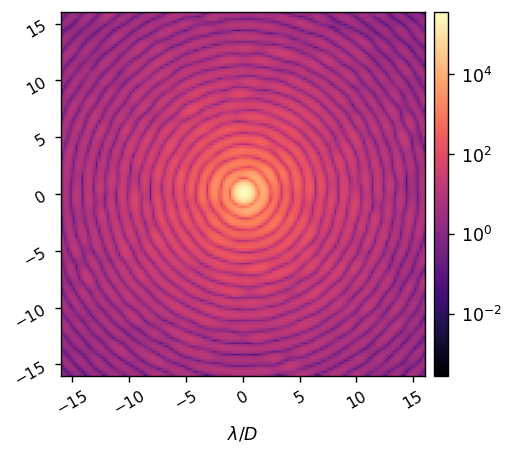

357688.99862226465


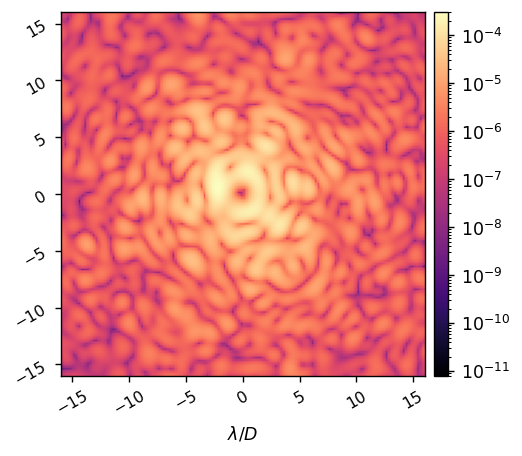

In [12]:
reload(hcim)
svc = hcim.SVC(npix=npix, oversample=oversample,
                 influence_functions=influence_functions,
                 ptv=60*u.nm,
                 psf_pixelscale_lamD=1/4,
                 dm1_dm2=1000*u.mm,
                 aberration_distance=50e-3*u.m)

print(svc.Nact, svc.Nacts)
imshow1(svc.dm_mask)

wf = hci.Wavefront(svc.aperture, svc.wavelength.to_value(u.m))
pupil_mask = wf.amplitude.shaped.astype(bool)
wf = svc.wfe_at_distance(wf)

amp = wf.amplitude.shaped
opd = wf.phase.shaped*svc.wavelength.to_value(u.m)/(2*np.pi)*pupil_mask
imshow2(amp, opd, npix=svc.npix)

rms_amp = np.sqrt(np.mean((amp[pupil_mask]-1)**2))
rms_wfe = np.sqrt(np.mean(opd[pupil_mask]**2))
print(rms_amp, rms_wfe)

svc.use_fpm = False
svc.norm = 1
ref_unocc_im = svc.snap()
imshow1(ref_unocc_im, pxscl=svc.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.max()
print(max_ref)

svc.use_fpm = True
svc.norm = max_ref # divide the source flux to get nominal contrast images
ref_im = svc.snap()
imshow1(ref_im, pxscl=svc.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

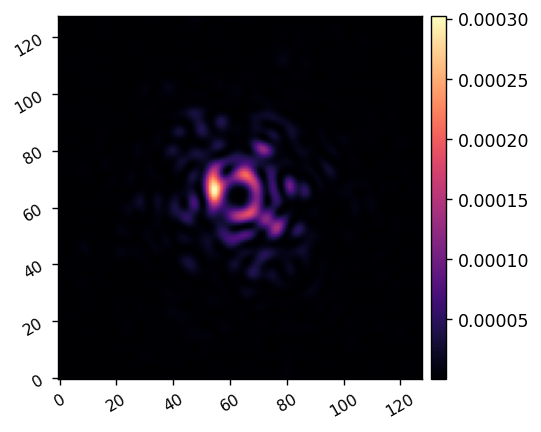

In [28]:
im = svc.snap()
imshow1(im)

In [ ]:
svc.

# Create dark hole ROI to calibrate and control

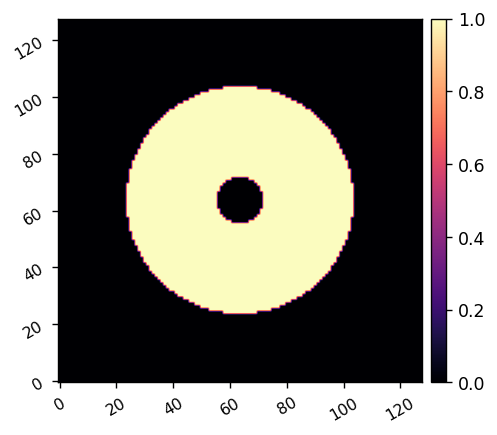

1.549961461380421e-05


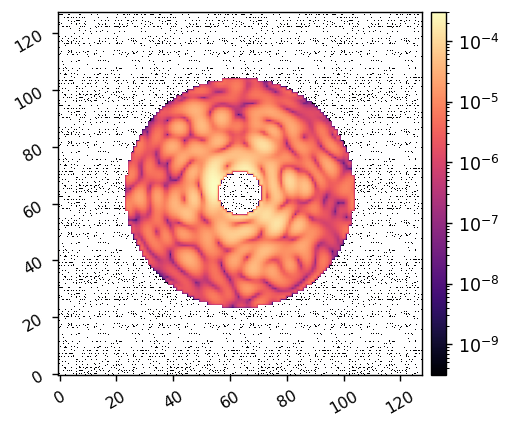

In [16]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None, plot=True)

mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

imshow1(control_mask*ref_im, lognorm=True)

# Create calibration modes


(1904, 2312)


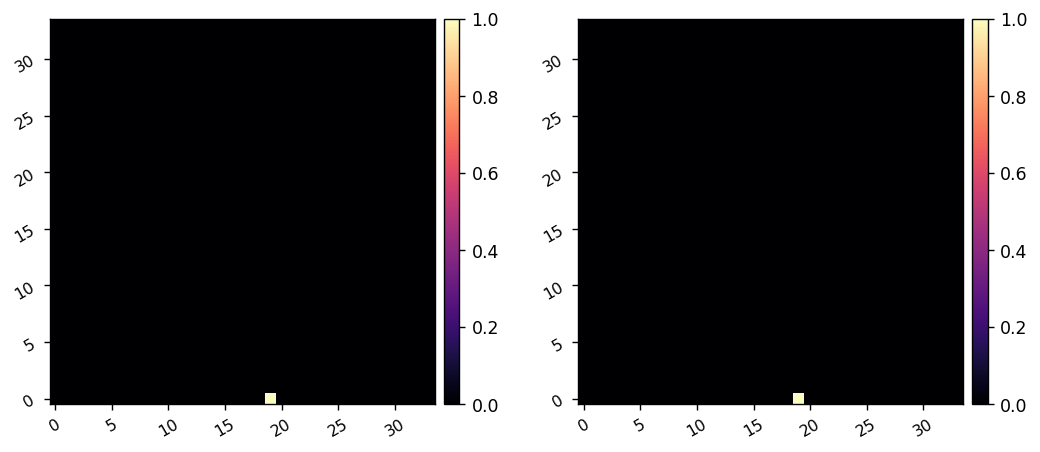

In [18]:
calib_modes = utils.create_all_poke_modes(svc.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:svc.Nact**2].reshape(svc.Nact,svc.Nact), calib_modes[i+svc.Nacts,svc.Nact**2:].reshape(svc.Nact,svc.Nact))


(2048, 2312)


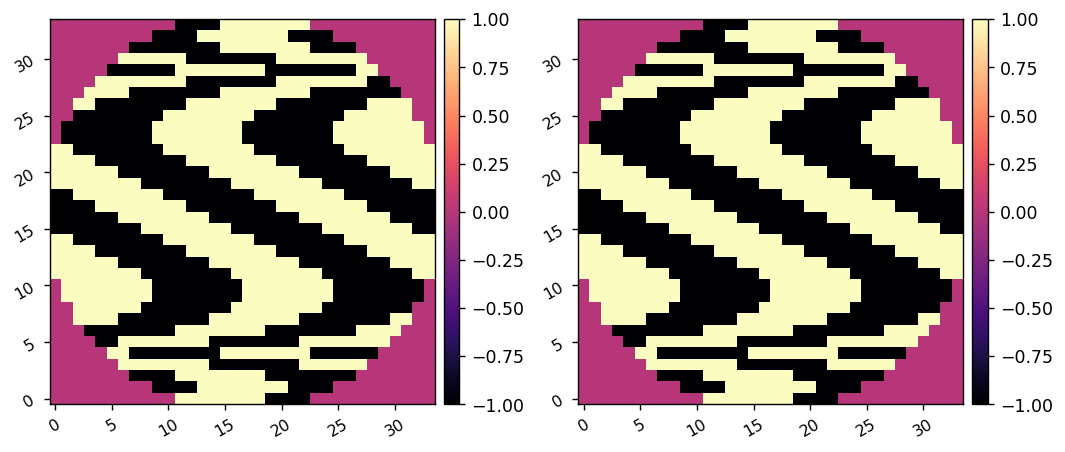

In [20]:
calib_modes = utils.create_hadamard_modes(svc.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:svc.Nact**2].reshape(svc.Nact,svc.Nact), calib_modes[i+1024,svc.Nact**2:].reshape(svc.Nact,svc.Nact))

In [21]:
3608/2 * 2.336/3600

1.1705955555555554

In [47]:
reload(efc_2dm)

calib_amp = 1e-9

jac = efc_2dm.build_jacobian(svc, calib_amp, calib_modes, control_mask,
                             plot_responses=True,
                            )

# utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


Calculating Jacobian: 


In [ ]:
utils.save_fits(response_dir/f'svc_efc_jacobian_hadamard_{today}.fits', jac)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/efc_jacobian_20231008.fits


In [5]:
date = 20231008
response_matrix = xp.array(fits.getdata(response_dir/f'efc_jacobian_{date}.fits'))

In [ ]:
response_matrix.shape
responses = response_matrix[::2] + 1j*response_matrix[1::2]

dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(calib_modes)))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
dm2_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1 Actuators:\nPoke Modes', 'RMS Response of DM2 Actuators:\nPoke Modes',
        lognorm=True, vmin1=1e2, vmin2=1e2,
        )


# Run EFC

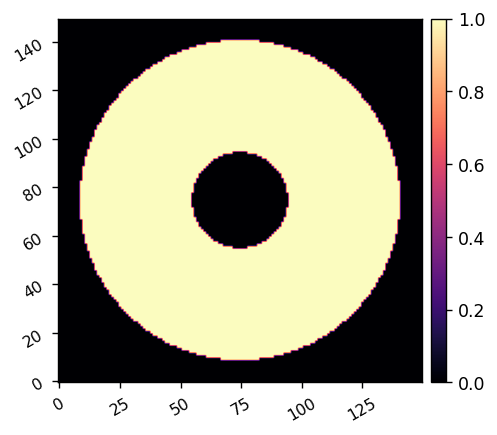

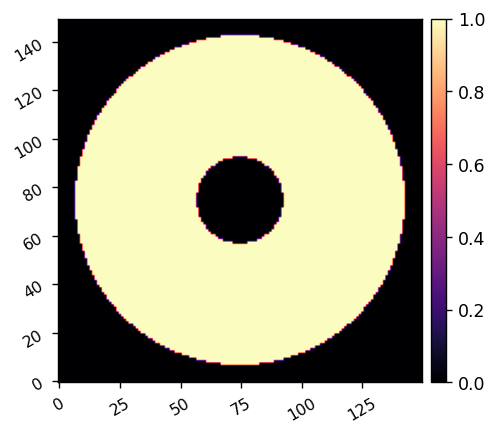

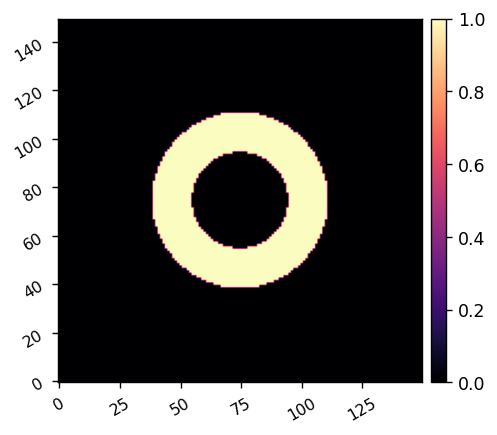

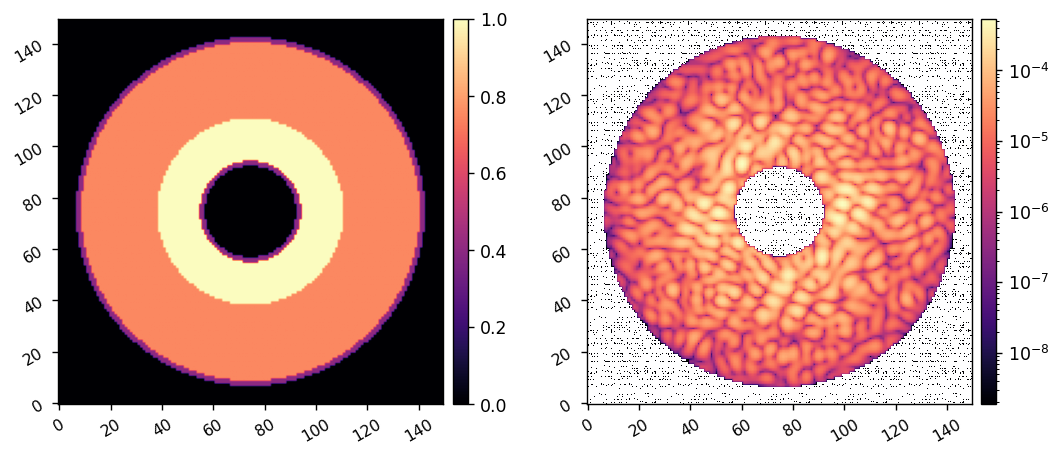

3.042688486608366e-05


In [7]:
reload(utils)

npsf = svc.npsf

roi1 = utils.create_annular_focal_plane_mask(svc, inner_radius=3, outer_radius=9, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(svc, inner_radius=3, outer_radius=5, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [9]:
mode.reset_dms()

In [10]:
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])

In [33]:
mode.set_dm1(ensure_np_array(dm1_commands[-8]))
mode.set_dm2(ensure_np_array(dm2_commands[-8]))

In [31]:
reload(utils)
reg_cond = 1e-3
# reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, algorithm='efc')
# control_matrix = utils.TikhonovInverse(response_matrix, reg_cond)
# probe_amp = 2e-8

control_matrix.shape


(3608, 27048) (27048, 27048) (27048, 3608)


(3608, 27048)

Beginning closed-loop EFC simulation.
Max singular value squared:	 20226878066071.746
alpha^2:			 4584673856292.34
	Running iteration 1/5.
	Mean NI of this iteration: 2.725e-09


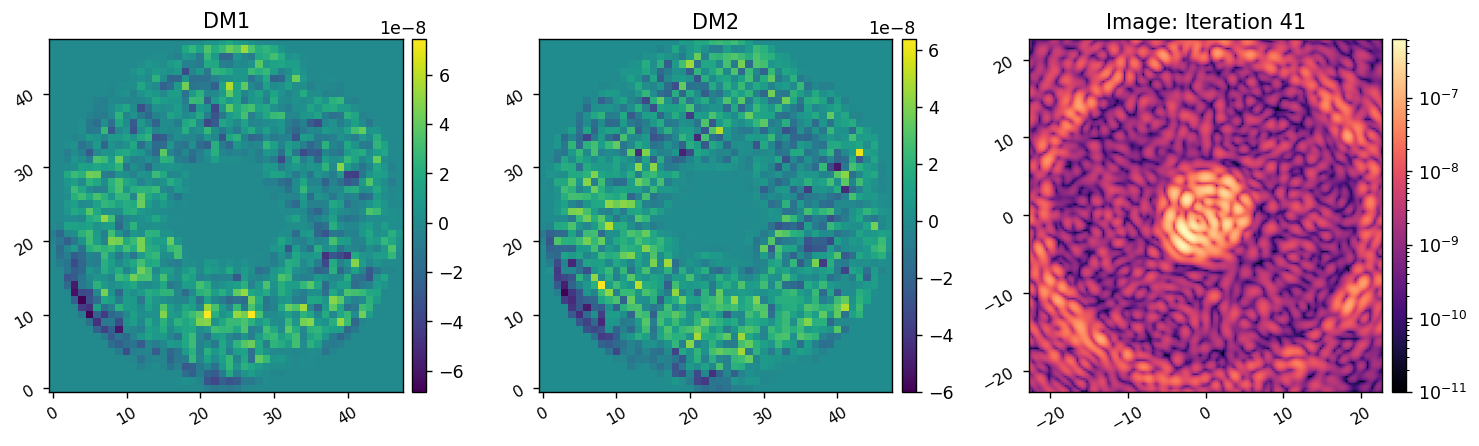

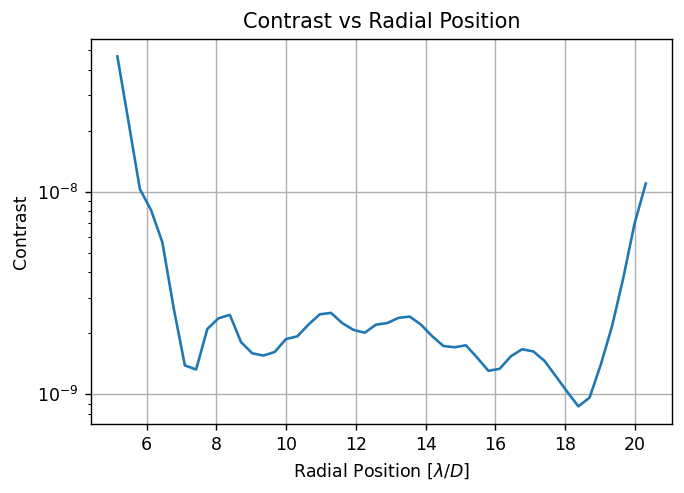

	Running iteration 2/5.
	Mean NI of this iteration: 2.627e-09


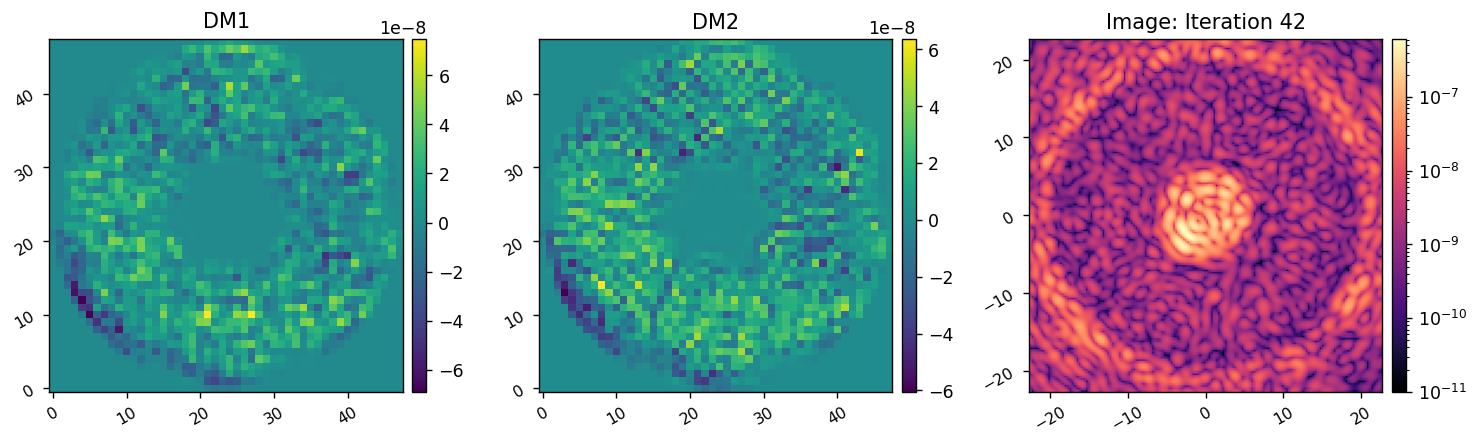

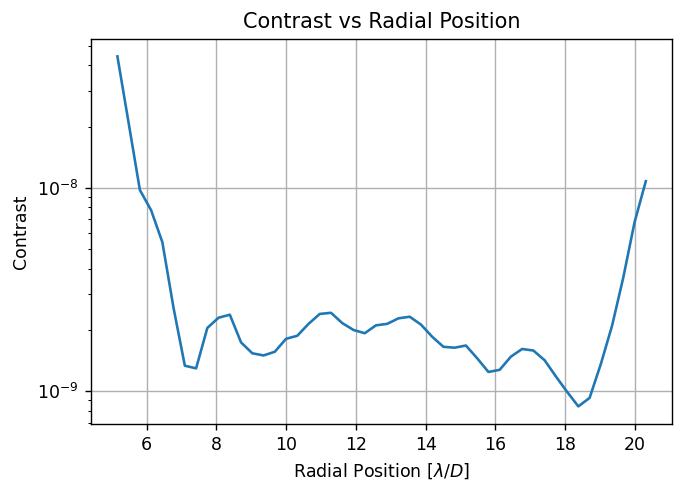

	Running iteration 3/5.
	Mean NI of this iteration: 2.534e-09


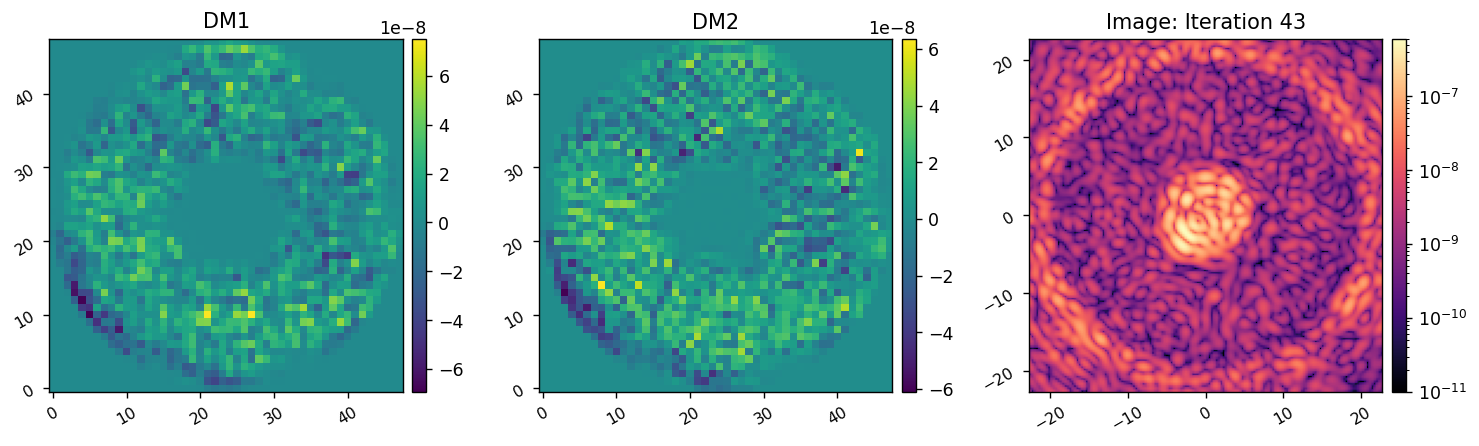

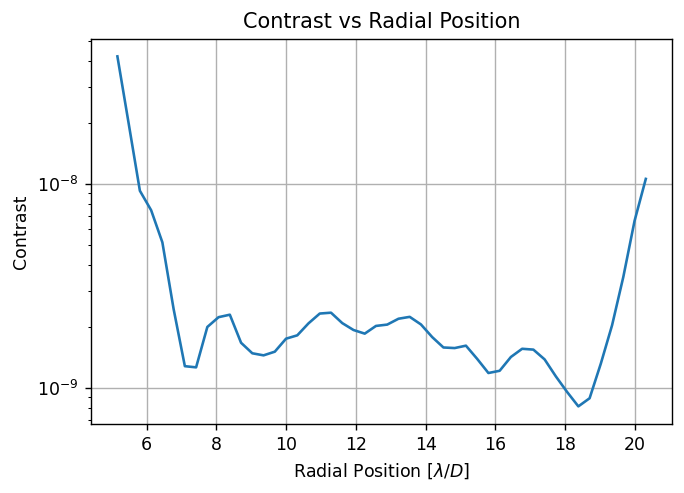

	Running iteration 4/5.
	Mean NI of this iteration: 2.447e-09


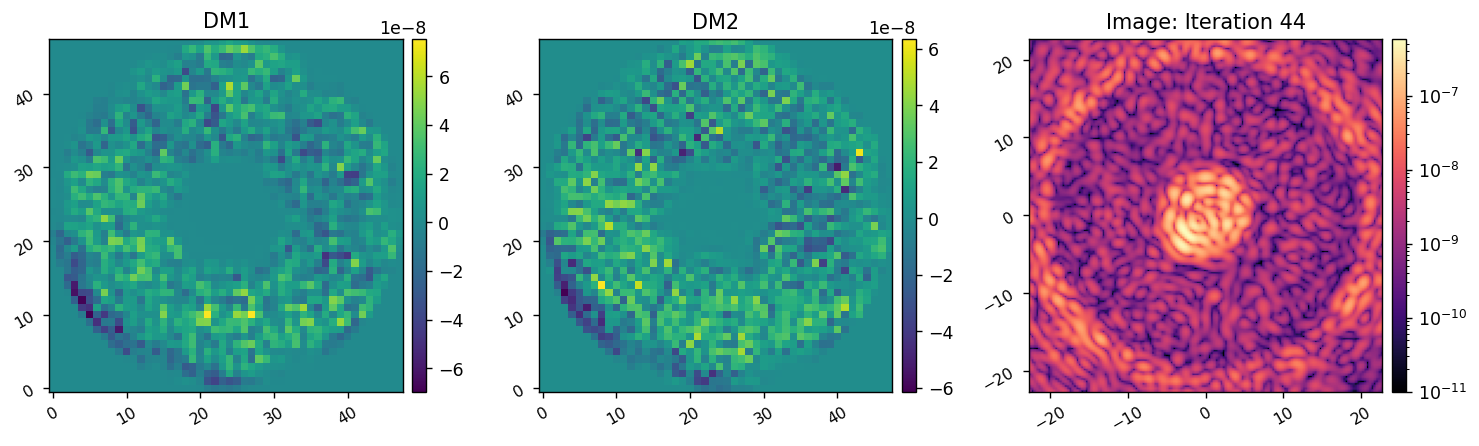

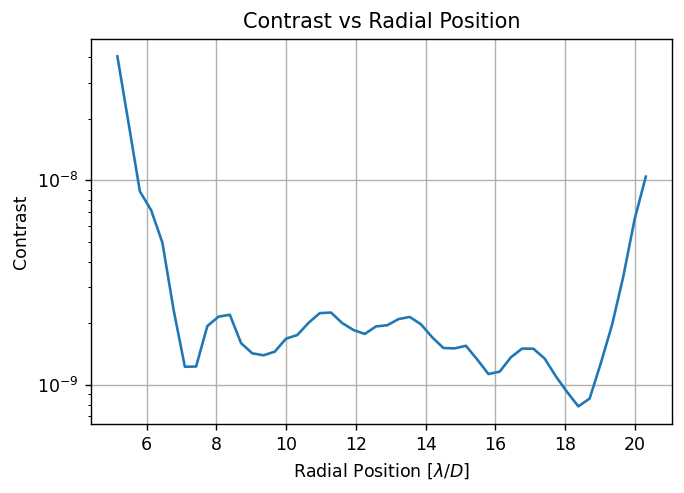

	Running iteration 5/5.
	Mean NI of this iteration: 2.365e-09


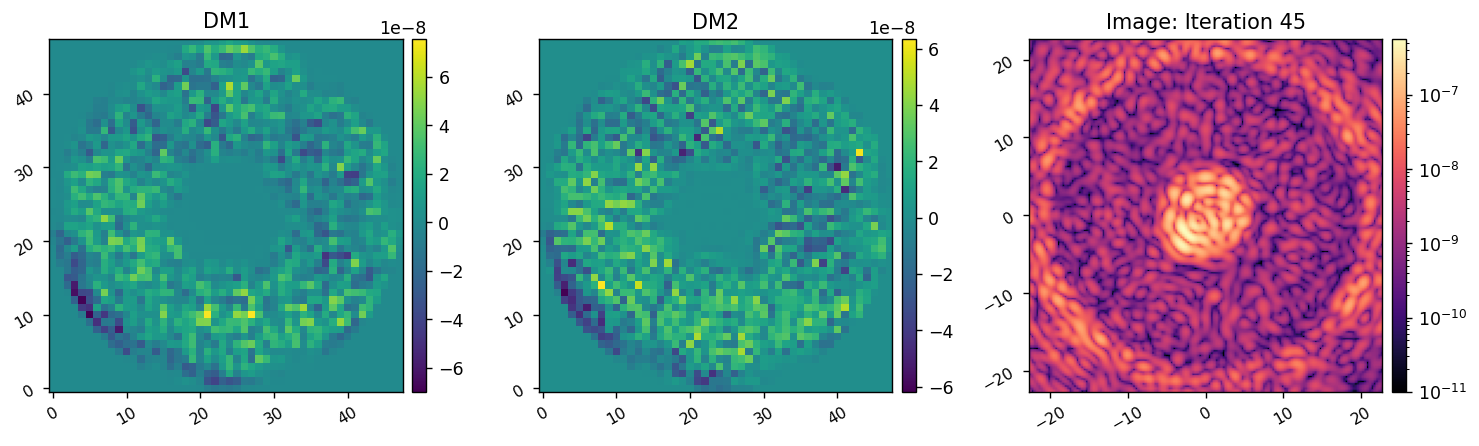

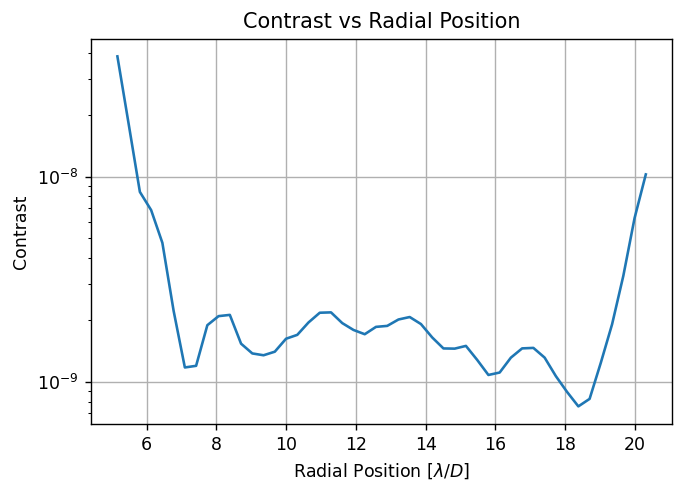

EFC completed in 9.379 sec.


In [33]:
reload(efc_2dm)

images, dm1_commands, dm2_commands = efc_2dm.run_efc_perfect(mode, 
                    response_matrix, 
                    calib_modes,
                    control_matrix,
                    control_mask, 
                    Imax_unocc=1,
                    loop_gain=0.5, 
                    leakage=0.0,
                    iterations=5, 
                    plot_all=True, 
                    plot_sms=False,
                    plot_radial_contrast=True,
                    old_images=images,
                    old_dm1_commands=dm1_commands,
                    old_dm2_commands=dm2_commands,
                    )



In [34]:
utils.save_fits(response_dir/f'svc_efc_dm1_commands_{date}.fits', dm1_commands)
utils.save_fits(response_dir/f'svc_efc_dm2_commands_{date}.fits', dm2_commands)
utils.save_fits(response_dir/f'svc_efc_images_{date}.fits', images)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_dm1_commands_20231008.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_dm2_commands_20231008.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_images_20231008.fits


# Now introduce FPM errors


In [23]:
svc.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([svc.get_dm1()])
dm2_commands = xp.array([svc.get_dm2()])

In [24]:
reload(utils)
reg_cond = 1e-3
# reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, algorithm='efc')
# control_matrix = utils.TikhonovInverse(response_matrix, reg_cond)
# probe_amp = 2e-8

control_matrix.shape

NameError: name 'response_matrix' is not defined

In [25]:
reload(efc_2dm)

images, dm1_commands, dm2_commands = efc_2dm.run_efc_perfect(svc, 
                    response_matrix, 
                    calib_modes,
                    control_matrix,
                    control_mask, 
                    Imax_unocc=1,
                    loop_gain=0.5, 
                    leakage=0.0,
                    iterations=5, 
                    plot_all=True, 
                    plot_sms=False,
                    plot_radial_contrast=True,
                    old_images=images,
                    old_dm1_commands=dm1_commands,
                    old_dm2_commands=dm2_commands,
                    )


NameError: name 'efc_2dm' is not defined